# Image Processing 101: Reading and Understanding image data

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from helper import *

In [2]:
sneaker_img = cv2.imread('images/Nike/Nike-100.00-61z2oRPGcuL._AC_SX510_.jpg', 0)

In [3]:
sneaker_img.shape

(225, 510)

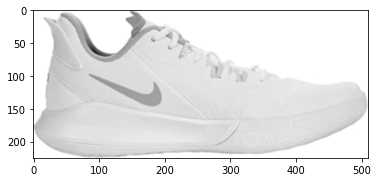

In [4]:
plt.imshow(sneaker_img, cmap='gray', interpolation='bicubic')

# Image Processing 101: Visualizing and Resizing an image

In [5]:
# Resizing
dim = (500, 200)
resized = cv2.resize(sneaker_img, dim, interpolation=cv2.INTER_AREA )

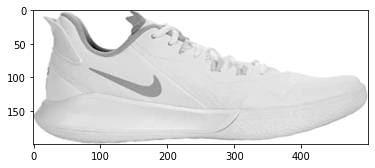

In [6]:
plt.imshow(resized, cmap='gray')

In [7]:
edges = cv2.Canny(resized, 100, 200)

(Text(0.5, 1.0, 'Edge Image'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

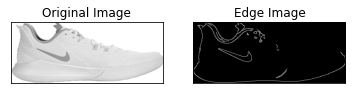

In [8]:
plt.subplot(121),plt.imshow(resized,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

# Image Processing 101: Vectorizing Images

I have put the code for loading all the image data in a separate python file (helper.py). Please check it out if you have any other questions. The load_image data will return 2 numpy array:
- dataset_features: a numpy array with shape (no_images, (image_width * image_height)) --> basically a numpy array with a stack of flatten image
- dataset_label: a numpy array with shape (no_image, 1) --> storing the label for correponding image

In [9]:
from helper import load_image_data, scree_plot_pca

# Load in the data
dataset_feature, dataset_label = load_image_data()

# Check out he data
print(f'Shape of feature array {dataset_feature.shape}')
print(f'Shape of label array {dataset_label.shape}')


Shape of feature array (1819, 127500)
Shape of label array (1819, 1)


# Train-Test split dataset

Before moving on doing any modeling task, we need to split the dataset into training set (for building the model) and testing set (for evaluation of the model)

In [10]:
from sklearn.model_selection import train_test_split

X_data = pd.DataFrame(data=dataset_feature)
Y_data = dataset_label.reshape((dataset_label.shape[0],))

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

(array([325.,   0., 268.,   0.,   0., 237.,   0., 376.,   0., 249.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

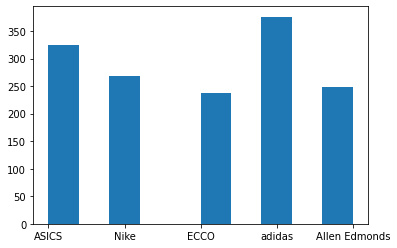

In [11]:
# Distribution of training set
plt.hist(y_train)

(array([74.,  0., 48.,  0.,  0., 77.,  0., 98.,  0., 67.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

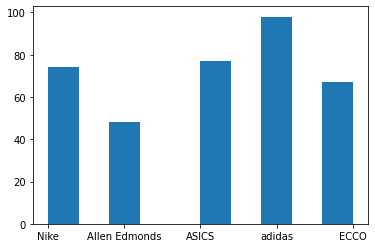

In [12]:
# Distribution of testing set
plt.hist(y_test)

# PCA and Logistic Regression

Before approaching this problem, there are already many different other deep learning techniques that proves powerful for the image classificiation task (CNN, ...). However, my purpose of this project is to re-learn some other more traditional machine learning algorithms and see how it work out. There are two possible workflows for this problem:

- Approach 1 (end-to-end deep learning): image --> CNN --> prediction
- Approach 2 (feature engineering + machine learning): image --> PCA --> compressed_version of image --> Logistic --> Prediction

We are going to approach 2 in this application. Note:

- The number of dimension to reduce is a hyperpameter to tune in order to get the best performance. I have palyed around with this number and decided to go with 300 PCs since it account for above 90% of explain variance ratio
- We have to save all of the objects during our preprocessing steps in order to use it later for the transformation of other dataset (this is the way that how to make sure our model perform seamlessley)

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

In [14]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)

#Dimensionality reduction with PCA
pca = PCA(n_components=300)
X_train_scaled_reduced = pca.fit_transform(X_train_scaled)

# Encode labels
encoder = LabelEncoder()
y_train_encode = encoder.fit_transform(y_train)

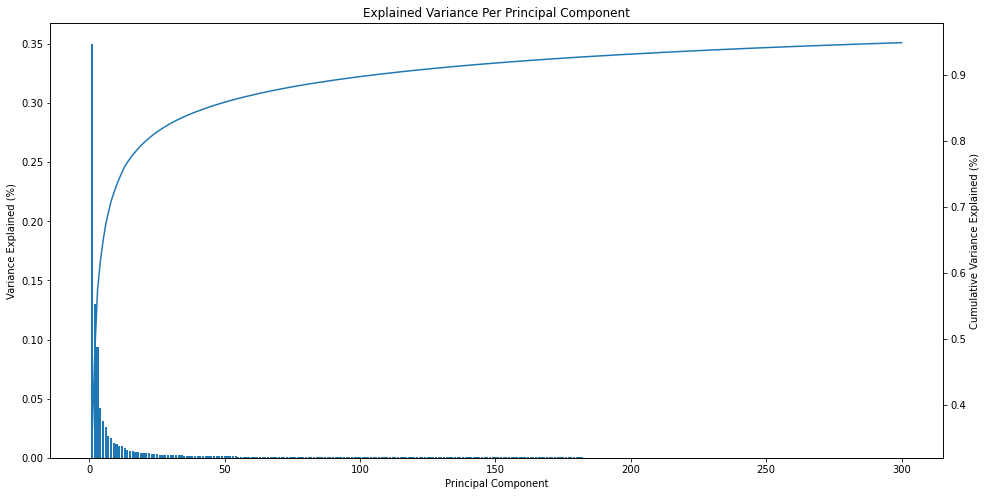

In [15]:
# Scree plot showing the explained variance per PCs
scree_plot_pca(pca)

In [16]:
# Fit the model and get some initial result
clf = LogisticRegression(penalty='l1', C=10.0, solver='saga')
clf.fit(X_train_scaled_reduced, y_train_encode)

y_pred_train = clf.predict(X_train_scaled_reduced)
print(confusion_matrix(y_train_encode, y_pred_train))
print(classification_report(y_train_encode, y_pred_train))

[[322   0   0   3   0]
 [  0 244   3   0   2]
 [  0   2 229   2   4]
 [  0   0   0 266   2]
 [  0   1   3  10 362]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       325
           1       0.99      0.98      0.98       249
           2       0.97      0.97      0.97       237
           3       0.95      0.99      0.97       268
           4       0.98      0.96      0.97       376

    accuracy                           0.98      1455
   macro avg       0.98      0.98      0.98      1455
weighted avg       0.98      0.98      0.98      1455



/Users/LocNguyen/Desktop/web-scrape-zappos/web-scrape-zappos/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


--> 98% for training test is a promising result. However, we need to run it thorugh the test set just one time to see how it goes

In [17]:
# All the transformation step needed for test set
X_test_scaled = scaler.transform(X_test.values)
X_test_scaled_reduced = pca.transform(X_test_scaled)
y_test_encode = encoder.transform(y_test)

# Do the prediction
y_pred_test = clf.predict(X_test_scaled_reduced)
print(classification_report(y_test_encode, y_pred_test))
print(confusion_matrix(y_test_encode, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89        77
           1       0.70      0.92      0.79        48
           2       0.84      0.81      0.82        67
           3       0.82      0.76      0.79        74
           4       0.84      0.82      0.83        98

    accuracy                           0.83       364
   macro avg       0.82      0.83      0.82       364
weighted avg       0.83      0.83      0.83       364

[[67  5  0  2  3]
 [ 0 44  2  0  2]
 [ 1  4 54  6  2]
 [ 5  3  2 56  8]
 [ 1  7  6  4 80]]


In [19]:
# We can inverse transform to know exactly how each class encode
y_pred_test_decode = encoder.inverse_transform(y_pred_test)
print(classification_report(y_test, y_pred_test_decode))

               precision    recall  f1-score   support

        ASICS       0.91      0.87      0.89        77
Allen Edmonds       0.70      0.92      0.79        48
         ECCO       0.84      0.81      0.82        67
         Nike       0.82      0.76      0.79        74
       adidas       0.84      0.82      0.83        98

     accuracy                           0.83       364
    macro avg       0.82      0.83      0.82       364
 weighted avg       0.83      0.83      0.83       364



83% is not a bad performance, but we can do it better. Let's now save the model and all the transformation objects for later use

In [20]:
from pickle import dump

# Dump model, scaler, pca, and encoder
dump(clf, open('model.pkl', 'wb'))
dump(scaler, open('scaler.pkl', 'wb'))
dump(pca, open('pca.pkl', 'wb'))
dump(encoder, open('encoder.pkl', 'wb'))

# Hyperparameter Tuning

In [22]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# Hyoerparameter tuning using gridsearch and cross validation
params_grid = [{'penalty': ['l1'], 'C':[1, 10, 100], 'solver':['saga'], 'random_state':[1]}, 
               {'penalty': ['l2'], 'C':[1, 10, 100], 'random_state':[2]},
               {'penalty': ['elasticnet'], 'C':[1, 10, 100], 'solver':['sag','saga','newton-cg'], 'l1_ratio':[0.5, 0.6, 0.7, 0.8], 'random_state':[3]}]

# Fit SVM model with 5 fold CV
logis_model = RandomizedSearchCV(LogisticRegression(), params_grid, n_jobs=-1, cv=5, verbose=1)
logis_model.fit(X_train_scaled_reduced, y_train_encode)

# View the accuracy score
print(f'Best score for training data:{logis_model.best_score_} \n')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    8.0s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.5s finished


Best score for training data:0.8116838487972509 



/Users/LocNguyen/Desktop/web-scrape-zappos/web-scrape-zappos/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


--> After fitting model and do a 5-fold cross validation, we come up with a accruacy of roughly 82%

In [23]:
logis_model.best_estimator_

LogisticRegression(C=10, l1_ratio=0.8, penalty='elasticnet', random_state=3,
                   solver='saga')

In [24]:
final_model = logis_model.best_estimator_

y_pred_test = final_model.predict(X_test_scaled_reduced)
print(classification_report(y_test_encode, y_pred_test))
print(confusion_matrix(y_test_encode, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89        77
           1       0.69      0.92      0.79        48
           2       0.84      0.81      0.82        67
           3       0.82      0.76      0.79        74
           4       0.84      0.81      0.82        98

    accuracy                           0.82       364
   macro avg       0.82      0.83      0.82       364
weighted avg       0.83      0.82      0.82       364

[[67  5  0  2  3]
 [ 0 44  2  0  2]
 [ 1  4 54  6  2]
 [ 5  3  2 56  8]
 [ 1  8  6  4 79]]


--> Not bad, we have tried a couple of way to prevent the overfitting issue such as:
- Try a simpler model
- Image augmentation (flip, rotate, add noise...)
- Regularization techniques (l1, l2, elasticnet, ...)
- Redisgn the dataset ...

# Image Augmentation

In [ ]:
def image_augment(image): 
        '''
        Create the new image with imge augmentation
        :param path: the path to store the new image
        ''' 
        img = image.copy()
        # Flip Image
        img_flip = cv2.flip(img, flipCode=0)
        
        # Rotate image
        w = img.shape[1]
        h = img.shape[0]
        M = cv2.getRotationMatrix2D((w/2,h/2), angle=90, scale=1.0)
        img_rotate = cv2.warpAffine(img,M,(w,h))
        
        return img_flip, img_rotate
        

In [ ]:
adidas_folder = 'images/ASICS/'
for file in os.listdir(adidas_folder):
    image = cv2.imread(f'{adidas_folder}{file}', 0)
    img_flip, img_rotate = image_augment(image)
    cv2.imwrite(f'{adidas_folder}{file}_vflip.jpg', img_flip)
    #cv2.imwrite(f'{adidas_folder}{file}_rot.jpg', img_rotate)

In [3]:
import pickle
ENCODER = pickle.load(open('./pkl_file/encoder.pkl', 'rb'))
PCA = pickle.load(open('./pkl_file/pca.pkl', 'rb'))

In [5]:
from compress_pickle import dump, load

dump(PCA, './pkl_file/pca_compressed.pkl')

In [4]:
a = np.array([0,1,2,3,4])

In [7]:
ENCODER.inverse_transform(a).shape

(5,)